# Implicit CF

In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import json


from scipy.sparse import coo_matrix, csr_matrix, save_npz

# EDA

In [2]:
DATA_FOLDER = "../input"
TMP_FOLDER = os.path.join(DATA_FOLDER, "tmp")

csv_data_filename = 'exercise.interactions.csv'

In [3]:
src_df = pd.read_csv(os.path.join(DATA_FOLDER, csv_data_filename), dtype=str)

#### Column Info

In [4]:
src_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3637044 entries, 0 to 3637043
Data columns (total 4 columns):
USER_ID       object
ITEM_ID       object
TIMESTAMP     object
EVENT_TYPE    object
dtypes: object(4)
memory usage: 111.0+ MB


#### Example:

In [5]:
src_df.head()

,USER_ID,ITEM_ID,TIMESTAMP,EVENT_TYPE
0,0001c4d4-13af-44c6-b653-a249ce2b2c7e,4644261659414259286,1553269070,submit
1,00042f84-5e34-4dd7-a459-cb8310457f2f,13388854895967500321,1553303518,submit
2,0005f128-5aee-43c1-8c44-eb1fe019179e,7269739074656998882,1553250200,submit
3,000810a5-8eff-47d6-9ead-97add9e07211,18406351456112377421,1553262896,submit
4,000a3365-cab3-41db-b67f-09988b5deff0,9595719689128501283,1553306334,submit


#### Data Info

In [6]:
print("number of interactions: " + str(src_df.shape[0]))
print("number of interactions after drop duplicates: " + str(src_df.drop_duplicates(subset=['USER_ID', 'ITEM_ID']).shape[0]))
print("number of unique users: " + str(src_df['USER_ID'].unique().shape[0]))
print("number of unique items: " + str(src_df['ITEM_ID'].unique().shape[0]))

number of interactions: 3637044
number of interactions after drop duplicates: 1484421
number of unique users: 97156
number of unique items: 224858


In [7]:
print("event types:")
src_df['EVENT_TYPE'].unique().tolist()

event types:


['submit', 'comment', 'favourite', 'view']

#### Item Cardinality Per User

In [8]:
groups = src_df.groupby('USER_ID')
group_size = groups.size()

(97156,)


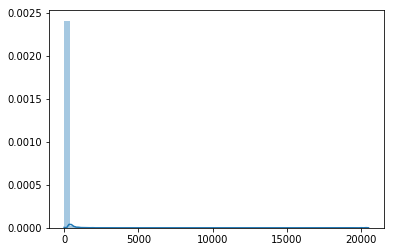

In [9]:
print(group_size.shape)
sns.distplot(group_size)

#### User Cardinality Per Item

In [10]:
groups = src_df.groupby('ITEM_ID')
group_size = groups.size()

(224858,)


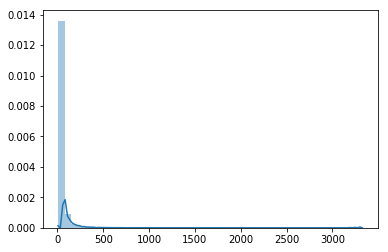

In [11]:
print(group_size.shape)
sns.distplot(group_size[group_size > 10])

# Preprocessing

In [12]:
# Remove duplicate [user, item] pairs
src_df.drop_duplicates(subset=['USER_ID', 'ITEM_ID'], inplace=True)
src_df.reset_index(drop=True, inplace=True)

In [13]:
# Remove new Items
groups = src_df.groupby('ITEM_ID')
group_size = groups.size()
item_index_pd = group_size[group_size >= 3].index
src_df = src_df[src_df['ITEM_ID'].isin(item_index_pd)]
src_df.reset_index(drop=True, inplace=True)

In [14]:
print("number of interactions: " + str(src_df.shape[0]))
print("number of unique users: " + str(src_df['USER_ID'].unique().shape[0]))
print("number of unique items: " + str(src_df['ITEM_ID'].unique().shape[0]))

number of interactions: 1307231
number of unique users: 85932
number of unique items: 90541


In [15]:
# Remove new users
groups = src_df.groupby('USER_ID')
group_size = groups.size()
user_index_pd = group_size[(group_size >= 5) & (group_size < 300)].index
src_df = src_df[src_df['USER_ID'].isin(user_index_pd)]
src_df.reset_index(drop=True, inplace=True)

In [16]:
print("number of interactions: " + str(src_df.shape[0]))
print("number of unique users: " + str(src_df['USER_ID'].unique().shape[0]))
print("number of unique items: " + str(src_df['ITEM_ID'].unique().shape[0]))

number of interactions: 1081823
number of unique users: 41086
number of unique items: 89775


# Convert To Implicit Matrix

#### Generate Metadata

In [17]:
metadata = dict()

In [18]:
# user id to index
user_ids = src_df['USER_ID'].unique().tolist()
user_index = dict([(user_ids[i], i) for i in range(len(user_ids))])

In [19]:
# item id to index
item_ids = src_df['ITEM_ID'].unique().tolist()
item_index = dict([(item_ids[i], i) for i in range(len(item_ids))])

In [20]:
metadata['user_index'] = user_index
metadata['item_index'] = item_index

#### Split Train and Test Set

In [21]:
tmp_id = np.asarray(list(range(src_df.shape[0])))
src_df['tmp_id'] = tmp_id

user_groups = src_df.groupby('USER_ID')
test_tmp_id = user_groups.apply(lambda x: x.sample(frac=0.5) if x.shape[0] >= 5 else None).reset_index(drop=True)['tmp_id']
test_mask = src_df['tmp_id'].isin(test_tmp_id)

train_df = src_df[~test_mask].drop(columns=['tmp_id']).reset_index(drop=True)
test_df = src_df[test_mask].drop(columns=['tmp_id']).reset_index(drop=True)

/Users/keyitang/miniconda3/envs/deviantart/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


#### Generate Sparse implicit Matrix

In [22]:
implicit_data = np.ones(train_df.shape[0], dtype=np.float32)

implicit_indices_user = train_df.apply(lambda row: user_index[row['USER_ID']], axis=1).values
implicit_indices_item = train_df.apply(lambda row: item_index[row['ITEM_ID']], axis=1).values
implicit_indices = np.stack((implicit_indices_item, implicit_indices_user))

implicit_matrix = csr_matrix((implicit_data, implicit_indices), (len(item_index), len(user_index)))

# Save Files

In [23]:
IMPLICIT_FOLDER = os.path.join(TMP_FOLDER, 'implicit_300items')

with open(os.path.join(IMPLICIT_FOLDER, 'metadata.json'), 'w') as fp:
    json.dump(metadata, fp)
    
train_df.to_csv(os.path.join(IMPLICIT_FOLDER, 'train_interactions.csv'), index=False)
test_df.to_csv(os.path.join(IMPLICIT_FOLDER, 'test_interactions.csv'), index=False)

save_npz(os.path.join(IMPLICIT_FOLDER, 'train_matrix.npz'), implicit_matrix)